## Homework 4: Neural Networks

**Due date:** May 4, 2022

The goal of the assignment is to train a simple neural network on MNIST data.

*Note:* This notebook requires Python 3.

**Instructions:**

* Read and understand the provided code, which is a basic implementation of a neural network as a modular architecture.
* Download the [MNIST data](http://deeplearning.net/data/mnist/mnist.pkl.gz) (~15Mo). It consists of 28x28 images (loaded as a 784 vector) and the associated labels for training, validation and test sets. For this homework, you will only use the training and validation sets. 
* Write a simple loop to train 50 iterations of the implemented MLP (multi-layer perceptron) with a learning rate 0.001 and batches of size 16. Plot the training and validation losses throughout the training process (you don't have to test your network at every iteration, you can do it for example every 10 iterations).
* Evaluate the accuracy of your trained model on the training and validation data. Check the predictions on random validation images.
* Try changing learning rate and batch size and see if you can improve your results.
* How many parameters does the network have? Implement and experiment with some variations of the architecture, for example:
    * Implement and use the cross-entropy loss instead of L2 loss.
    * Add a parameter to vary the size of the intermediate layer.
    * Use a MLP with 3 layers and parameters for the sizes of the two intermediate layers.


*MLP implementation*

In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['image.cmap'] = 'gray' 
import gzip
import pickle
import os


class Module(object):
    def __init__(self):
        self.gradInput=None 
        self.output=None
        
    def forward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x):
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        

class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    

class MLP(Module):

    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

#### Download the [MNIST data](https://figshare.com/articles/dataset/mnist_pkl_gz/13303457/1). It consists of 28x28 images (loaded as a 784 vector) and the associated labels for training, validation and test sets.

5


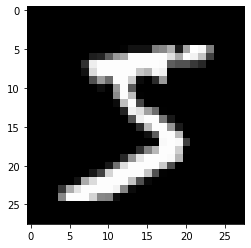

In [2]:
path = os.getcwd() 
f = gzip.open(path + '/mnist.pkl.gz', 'rb') 
train_set, val_set, test_set = pickle.load(f, encoding='latin1')
f.close()

train_data=train_set[0]
train_labels=train_set[1]
val_data=val_set[0]
val_labels=val_set[1]
N_train=train_data.shape[0]
N_val=val_data.shape[0]

plt.imshow(train_data[0,:].reshape(28,28))
print(train_labels[0])

#### Write a simple loop to train 50 iterations of the implemented MLP (multi-layer perceptron) with a learning rate 0.001 and batches of size 16. Plot the training and validation losses throughout the training process.

In [3]:
def train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels):
    
    n_train, n_val = len(train_data), len(val_data)
    train_loss = np.empty([num_epochs, int(n_train/batch_size)])
    val_loss = np.empty([num_epochs, int(n_val/batch_size)])
    
    for epoch in range(num_epochs):
        
        for i in range(int(n_train/batch_size)):
            x = train_data[batch_size*i:batch_size*(i+1)]
            y = train_labels[batch_size*i:batch_size*(i+1)]
            y_pred = model.forward(x)
            train_loss[epoch, i] = criterion.forward(y_pred, y)
            grad0 = criterion.backward(y_pred, y)
            grad = model.backward(x, grad0)
            model.gradientStep(learn_rate)  

        for j in range(int(N_val/batch_size)):
            x = val_data[batch_size*j:batch_size*(j+1)]
            y = val_labels[batch_size*j:batch_size*(j+1)]
            y_pred = model.forward(x)
            val_loss[epoch, j] = criterion.forward(y_pred, y)
            
        if (epoch+1) % 10 == 0:
            print('Training epoch:', epoch+1)
            
    plt.plot(np.mean(train_loss, axis=1))
    plt.plot(np.mean(val_loss, axis=1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','val'])
    plt.show()

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50


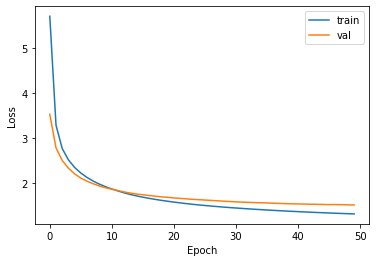

In [4]:
num_epochs = 50
learn_rate = 1e-3
batch_size = 16
model = MLP()
criterion = LeastSquareCriterion()
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)

#### Evaluate the accuracy of your trained model on the training and validation data. Check the predictions on random validation images.

In [5]:
def evaluate_model(model, val_data, val_labels, batch_size, num_samples):
    
    n_val = len(val_data)
    y_pred = np.empty([int(n_val/batch_size), batch_size])
    
    for i in range(int(n_val/batch_size)):
        x = val_data[batch_size*i:batch_size*(i+1)]
        y = val_labels[batch_size*i:batch_size*(i+1)]
        y_pred[i,:] = np.argmax(model.forward(x),axis=1)
    
    rand_index = np.random.randint(len(val_data), size=num_samples)
    model_accuracy = (y_pred.flatten()[rand_index]==val_labels[rand_index]).mean()

    return model_accuracy

In [6]:
num_samples = int(1e3)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

Model accuracy: 0.974


#### Try changing learning rate and batch size and see if you can improve your results.

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50


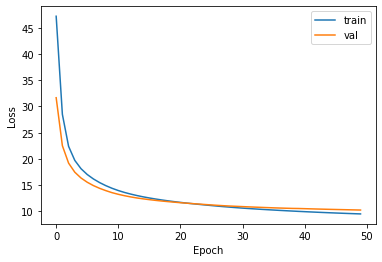

Model accuracy: 0.975


In [7]:
num_epochs = 50
learn_rate = 1e-3/2
batch_size = 100
model = MLP()
criterion = LeastSquareCriterion()
num_samples = int(1e3)
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

#### How many parameters does the network have?

(784 input units * 64 weights + 64 biases) + (64 hidden units * 10 weights + 10 biases) = 50,890 parameters

#### Implement and use the cross-entropy loss instead of L2 loss.

In [8]:
class CrossEntropyCriterion(Module):
    """
    This implementation of the cross-entropy loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(CrossEntropyCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = -np.sum(target * np.log(np.abs(x) + 1e-8))
        return self.output
            
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]]=x[i,labels[i]]-1
        return self.gradInput

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50


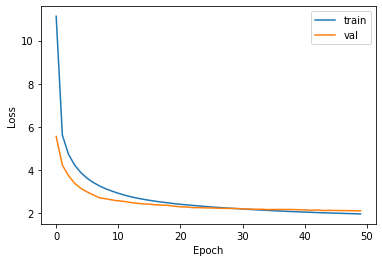

Model accuracy: 0.966


In [9]:
num_epochs = 50
learn_rate = 1e-3
batch_size = 16
model = MLP()
criterion = CrossEntropyCriterion()
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

#### Add a parameter to vary the size of the intermediate layer.

In [10]:
class MLP(Module):

    def __init__(self, hidden_size, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, hidden_size)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_size, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50


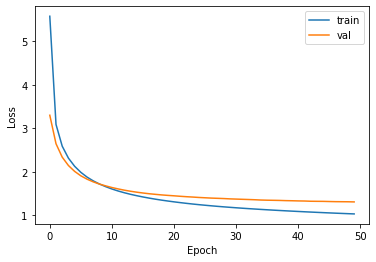

Model accuracy: 0.977


In [11]:
num_epochs = 50
learn_rate = 1e-3
batch_size = 16
model = MLP(hidden_size=128)
criterion = LeastSquareCriterion()
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

#### Use a MLP with 3 layers and parameters for the sizes of the two intermediate layers.

In [12]:
class MLP(Module):

    def __init__(self, hidden_size_1, hidden_size_2, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, hidden_size_1)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_size_1, hidden_size_2)
        self.relu2 = ReLU()
        self.fc3 = Linear(hidden_size_2, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output,gradient)
        gradient = self.relu2.backward(self.fc2.output,gradient)
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50


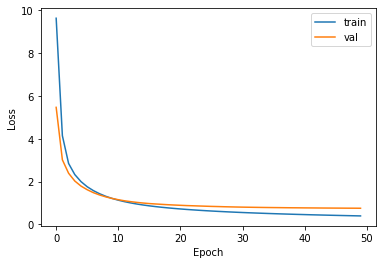

Model accuracy: 0.985


In [13]:
num_epochs = 50
learn_rate = 1e-3
batch_size = 16
model = MLP(hidden_size_1=128, hidden_size_2=36)
criterion = LeastSquareCriterion()
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)